In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from statistics import median
import os

fp = 'H:\\My Drive\\PROJECTS\\PSI 2022-2025\\XRF fundamentals vs. MVA'

### Sensitivity

In [57]:
df = pd.read_csv(fp+'\\misc\\duplicate_spectra_list.csv')
# select '18 samples
df = df[df.spectrum>=1800000000].reset_index(drop=True)

#samples with only one run to remove (maybe because had ones in '17?)
filt1_counts = pd.DataFrame(df[df['filter']==1]['sample'].value_counts()).reset_index()
to_remove = list(filt1_counts[filt1_counts['sample']==1]['index'])

In [58]:
# get spectrum/sample pkey match from predictions file
key = pd.read_csv('Z:\\data_pXRF\\Olympus_instrument_predictions.csv')
df = key[['spectrum_number','pkey']].merge(df, how='right', left_on='spectrum_number', right_on='spectrum').drop(columns='spectrum_number')

# those with only one spectrum number would not have both filters, so remove them
temp = df.groupby('pkey', as_index=False).size().sort_values('size')
to_remove = temp[temp['size']==1]['pkey'].values
df = df[~df.pkey.isin(to_remove)].reset_index(drop=True)

In [61]:
folder='Z:\\data_pXRF\\olympus_17_csv'

pkey_list = []
spectra_list = []
for p in tqdm(df.pkey.unique()):
    temp = df[df.pkey==p].copy().sort_values('filter')
    spectra = list(temp.spectrum.values)
    
    new_spectrum = []
    info = {
        '1':[],
        '2':[]
    }
    for spectrum in spectra:
        csv = pd.read_csv(f'{folder}\\{spectrum}.csv')
        
        beam = csv.loc['Beam','Olympus DELTA Premium Spectrum']
        res = csv.loc['eV per channel','Olympus DELTA Premium Spectrum']
        info[beam].append(res)
        
        s = list(csv['Olympus DELTA Premium Spectrum'][5:])
        new_spectrum.extend(s)
        
    for key in ['1','2']:
        if len(set(info[key])) > 1:
            print(f'Beam {key} does not have the same resolutions: {info[key]}')
            continue
            
    pkey_list.append(p)
    spectra_list.append(new_spectrum)
    
spectra = pd.DataFrame(spectra_list, index=pkey_list).T

  0%|          | 0/315 [00:00<?, ?it/s]

Median sensitivity: 46.8
Mean sensitivity: 108.5


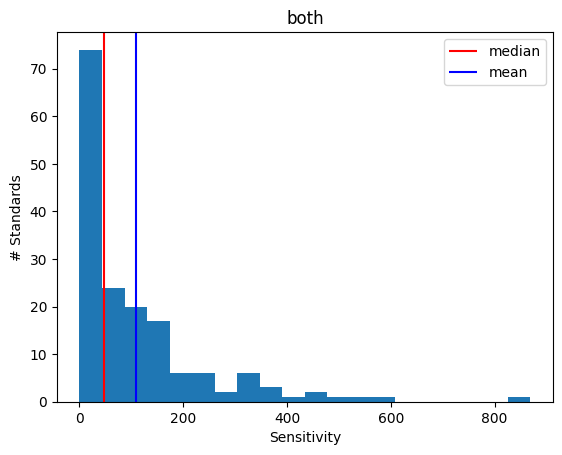

Median sensitivity: 29.3
Mean sensitivity: 48.7


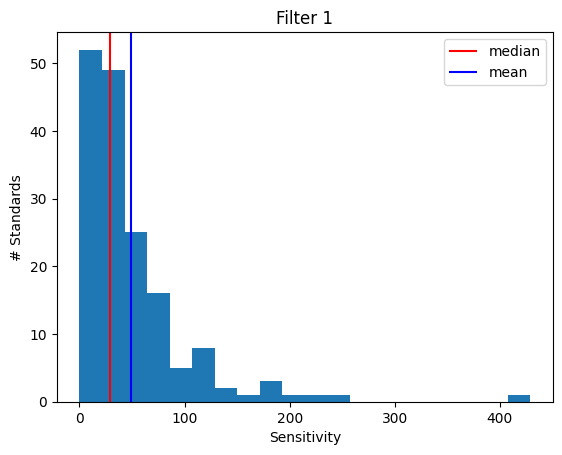

Median sensitivity: 65.4
Mean sensitivity: 168.2


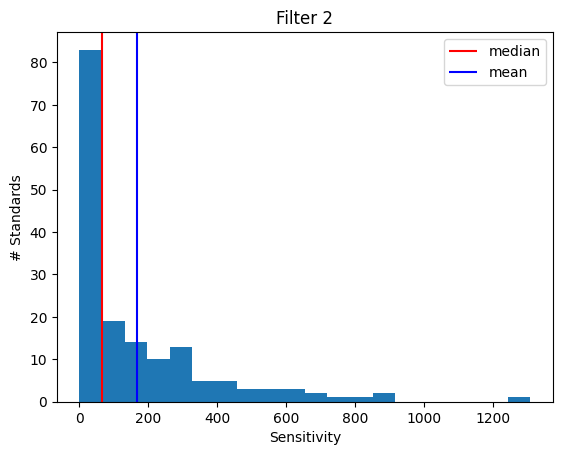

In [75]:
both_list = []
filt1_list = []
filt2_list = []
for sample in df['sample'].unique():
    spectra_list = list(df[df['sample']==sample]['pkey'])
    if len(spectra_list)<2:
        continue
    temp = spectra[spectra_list]
    temp = temp.astype('float').std(axis=1)
    
    both_sens = temp.mean()
    filt1_sens = temp[:2048].mean()
    filt2_sens = temp[2048:].mean()
    
    both_list.append(both_sens)
    filt1_list.append(filt1_sens)
    filt2_list.append(filt2_sens)
    
d = {
    'both':both_list,
    'Filter 1':filt1_list,
    'Filter 2':filt2_list
}

med_list = []
mean_list = []

for name in d.keys():
    l = d[name]
    
    median_sens = round(median(l),9)
    print("Median sensitivity:", round(median_sens,1))
    med_list.append(median_sens)

    mean_sens = sum(l)/len(l)
    print("Mean sensitivity:", round(mean_sens,1))
    mean_list.append(mean_sens)

    # compare median to mean
    med_c = 'red'
    mean_c = 'blue'

    plt.hist(l, bins=20)
    plt.ylabel("# Standards")
    plt.xlabel("Sensitivity")
    y_bot, y_top = plt.ylim()
    plt.vlines(x=median_sens,
               ymin = 0,
               ymax = y_top,
               colors=med_c,
               label='median')
    plt.vlines(x=mean_sens,
               ymin = 0,
               ymax = y_top,
               colors=mean_c,
               label='mean')
    plt.title(name)
    plt.legend()
    plt.ylim((0,y_top))
    plt.show()
    
pd.DataFrame({
    'filter':d.keys(),
    'median':med_list,
    'mean':mean_list
}).to_csv(fp+'\\sensitivities.csv', index=False)